In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import arviz as az

In [2]:
az.style.use('arviz-white')

# Metropolis sampling for the concussions data with adaptive tuning

Let $Y_i$ be the number of concussions (aggregated over all teams and games) in season i (1=2012,…,4=2015). We model these counts as:

$$Y_i\sim\mbox{Poisson}(N\lambda_i) \mbox{  where  } \lambda_i=\exp(\beta_1+i\beta_2)$$

where $N$ is the number of games played per year and $\lambda_i$ is the rate in year $i$. To complete the Bayesian model, we specify uninformative priors $\beta_1,\beta_2\sim\mbox{Normal}(0,\tau^2)$.


The log of the mean concussion rate is linear in time with $\beta_2$
determining the slope. The objective is to determine if the concussion rate is increasing, i.e., $\beta_2>0$.

In this analysis of these data with this algorithm, we tune the Metropolis candidate distributions during the burn-in period. The objective to tune the sampler so the acceptance rate is around 0.4 for all parameters. We check the acceptance proportion in the last 100 iterations and adjust the candidate SD if the acceptance probability is far from 0.4.

## Initialize

In [3]:
Y =  np.array([171, 152, 123, 199])
t =  np.arange(4)
n =  4
N =  256

## Compute the posterior on a grid for reference

In [4]:
# Create an empty matrix for the MCMC samples

S = 25000
samples = np.zeros((S, 2))
fitted = np.zeros((S, 4))

# Initial values

beta = np.array([np.log(np.mean(Y/N)), 0])

# priors: beta[j] ~ N(0, tau^2)

tau = 10
sd = (1 / tau)**0.5

# candidate standard deviations

can_sd = [1, 1]

##  Define the log posterior as a function

In [5]:
def log_post(Y, N, t, beta, sd):
    mn = N * np.exp(beta[0] + beta[1] * t)
    like = stats.poisson(mn).logpmf(Y).sum()
    prior = stats.norm(0, sd).logpdf(beta).sum()
    post = like + prior
    return post

## Metropolis sampling

In [6]:
burn = 5000      # Length of burn-in period for tuning
check = 100       # Iterations between checks of the acceptance rate
att = np.zeros(2)  # Keep track of the number of MH attempts
acc = np.zeros(2)  # Keep track of the number of MH accepts


for s in range(S):
    for j in range(2):
        att[j] += 1
        can = np.copy(beta)
        can[j] = stats.norm(beta[j], can_sd[j]).rvs(1)
        logR = log_post(Y, N, t, can, sd) - log_post(Y, N, t, beta, sd)
        if np.log(stats.uniform(0, 1).rvs(1)) < logR:
            beta = can
            acc[j] += 1

    # TUNING!
    for j in range(len(att)):
        if s < burn and att[j] == check:
            print(f"Can sd of {round(can_sd[j],3)} for beta[{j}] gave acc rate {acc[j]/att[j]}")
            if acc[j] / att[j] < 0.2:
                can_sd[j] *= 0.8
            elif acc[j] / att[j] > 0.6:
                can_sd[j] *= 1.2
            acc[j] = 0
            att[j] = 0

    samples[s:, ] = beta
    fitted[s:, ] = N * np.exp(beta[0] + beta[1]*t)

Can sd of 1 for beta[0] gave acc rate 0.05
Can sd of 1 for beta[1] gave acc rate 0.02
Can sd of 0.8 for beta[0] gave acc rate 0.05
Can sd of 0.8 for beta[1] gave acc rate 0.03
Can sd of 0.64 for beta[0] gave acc rate 0.1
Can sd of 0.64 for beta[1] gave acc rate 0.08
Can sd of 0.512 for beta[0] gave acc rate 0.11
Can sd of 0.512 for beta[1] gave acc rate 0.04
Can sd of 0.41 for beta[0] gave acc rate 0.14
Can sd of 0.41 for beta[1] gave acc rate 0.05
Can sd of 0.328 for beta[0] gave acc rate 0.13
Can sd of 0.328 for beta[1] gave acc rate 0.05
Can sd of 0.262 for beta[0] gave acc rate 0.15
Can sd of 0.262 for beta[1] gave acc rate 0.08
Can sd of 0.21 for beta[0] gave acc rate 0.25
Can sd of 0.21 for beta[1] gave acc rate 0.08
Can sd of 0.21 for beta[0] gave acc rate 0.24
Can sd of 0.168 for beta[1] gave acc rate 0.09
Can sd of 0.21 for beta[0] gave acc rate 0.25
Can sd of 0.134 for beta[1] gave acc rate 0.19
Can sd of 0.21 for beta[0] gave acc rate 0.22
Can sd of 0.107 for beta[1] gave ac

In [7]:
sampler_dict = {'β1': samples[:,0], 'β2': samples[:,1]}

## Compute the acceptance rates and plot the samples

In [8]:
# Acceptance rates 
np.mean(np.diff(samples, axis=0) > 0, 0)

array([0.15824633, 0.15956638])

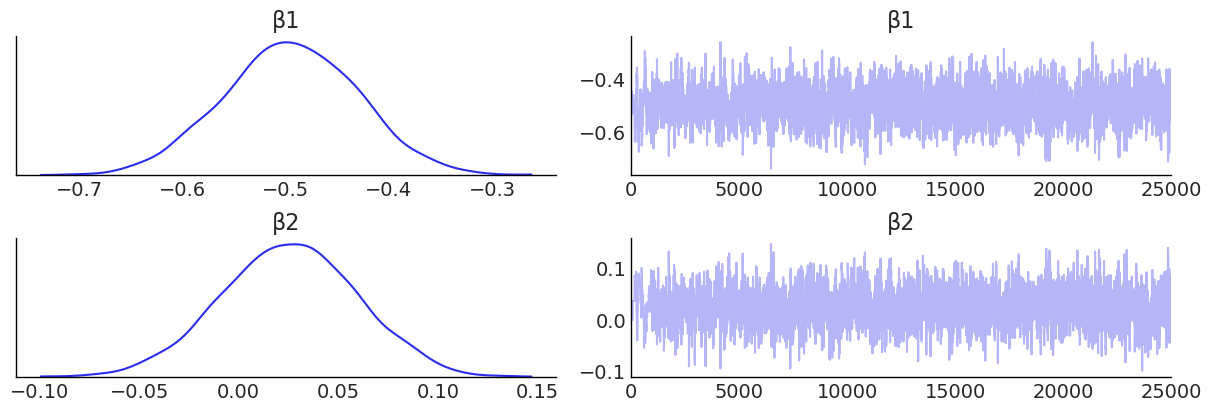

In [9]:
az.plot_trace(sampler_dict);

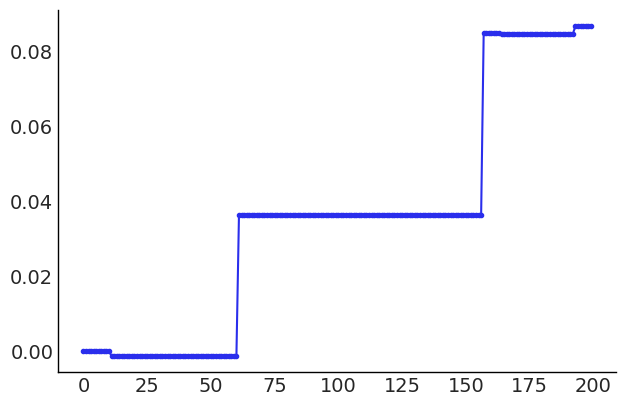

In [10]:
plt.plot(samples[:200,1], '.-');

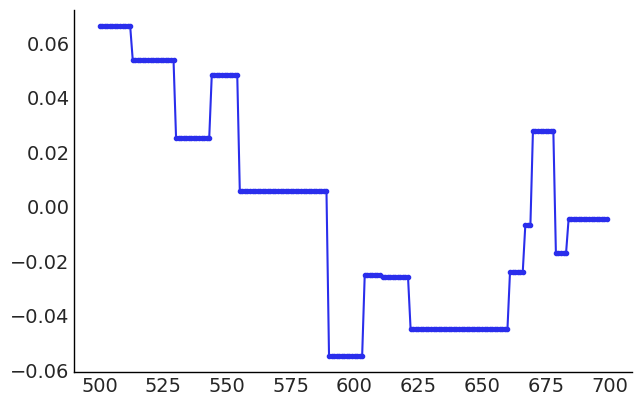

In [11]:
plt.plot(range(500, 700), samples[500:700,1], '.-');

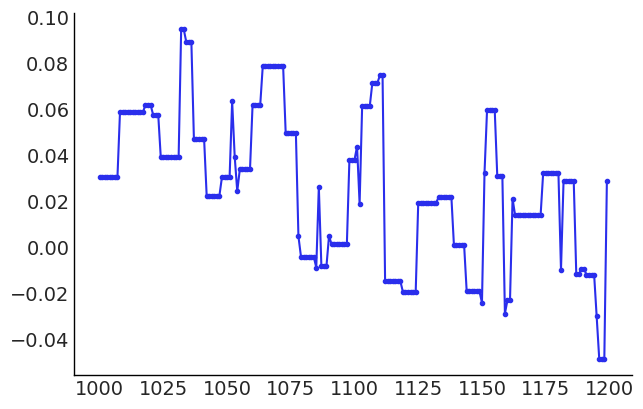

In [12]:
plt.plot(range(1000, 1200), samples[1000:1200,1], '.-');

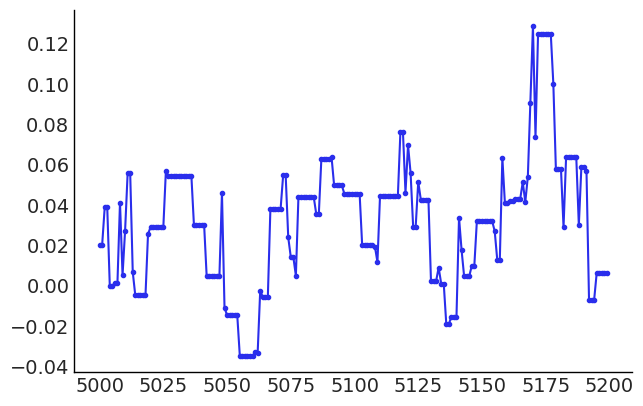

In [13]:
plt.plot(range(5000, 5200), samples[5000:5200,1], '.-');

Mixing improves as the candidate sd is tuned.